In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cplex
import cvxopt
import cvxpy as cp
import cyipopt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the return data
# may need to modify the path to run the code if using absolute path
df = pd.read_csv("./related_files/combined_adj_prices.csv")

## calculate necessary parameters

In [3]:
# rf rates are calculated as the averaged 10 year treasuary bond rate for 2005 and 2008
rf = (4.289+ 4.795 +4.635+3.664)/4/100
rf_m = rf/12

In [4]:
rf_m

0.003621458333333333

In [5]:
# mkt cap are all in Billions, take average values of market cap during 2005-2008 for each company
mkt_cap = [ 12.14  ,  37.62,  55.25  ,  58.28 , 113.58 , 101.79 ,
       199.39 , 180.79 , 105.76  , 142.56 ,  95.95, 134.36 ,
       157.31  , 181.30 , 423.45 ,  29.26,  11.92, 184.27  ,
       104.48 ,  20.69]
mkt_cap = np.array(mkt_cap)
w_cap = mkt_cap / sum(mkt_cap)
w_cap

array([0.00516563, 0.01600749, 0.02350914, 0.02479842, 0.04832883,
       0.04331213, 0.08484139, 0.076927  , 0.04500138, 0.06065996,
       0.04082718, 0.05717082, 0.06693615, 0.07714401, 0.18017999,
       0.01245027, 0.00507202, 0.07840776, 0.04445674, 0.00880369])

In [6]:
df2=df.iloc[:,1:].pct_change().shift(-1)
ret_all = df2.iloc[:-1,:]
# 2004.12.30 - 2008.9.30 return
ret_t = ret_all.iloc[:-2,:]
# 2008.10 return
ret_oct = ret_all.iloc[-2,:]
# 2008.11 return
ret_nov = ret_all.iloc[-1,:]

In [7]:
ret_oct

F      -0.578846
CAT    -0.352595
DIS    -0.155751
MCD    -0.061102
KO     -0.166793
PEP    -0.200084
WMT    -0.068125
C      -0.326119
WFC    -0.092726
JPM    -0.109887
AAPL   -0.053405
IBM    -0.205113
PFE    -0.039588
JNJ    -0.114607
XOM    -0.045583
MRO    -0.270128
ED      0.008380
T      -0.021047
VZ     -0.060453
NEM    -0.320434
Name: 45, dtype: float64

In [8]:
ret_nov

F       0.228310
CAT     0.073036
DIS    -0.130838
MCD     0.023160
KO      0.072822
PEP    -0.005438
WMT     0.001254
C      -0.392674
WFC    -0.143245
JPM    -0.232485
AAPL   -0.138675
IBM    -0.117391
PFE    -0.055864
JNJ    -0.037058
XOM     0.087573
MRO    -0.092181
ED     -0.054539
T       0.066866
VZ      0.100438
NEM     0.277525
Name: 46, dtype: float64

## sample mean

In [9]:
dict1 = pd.DataFrame(ret_t.mean()).to_dict()[0]
dict1 = {key : round(dict1[key], 8) for key in dict1}
dict1

{'F': -0.01427607,
 'CAT': 0.00808846,
 'DIS': 0.00413067,
 'MCD': 0.01795522,
 'KO': 0.0081466,
 'PEP': 0.00927311,
 'WMT': 0.00505742,
 'C': -0.01194779,
 'WFC': 0.00951754,
 'JPM': 0.00969113,
 'AAPL': 0.03706332,
 'IBM': 0.00649203,
 'PFE': -0.00322543,
 'JNJ': 0.0044066,
 'XOM': 0.01257922,
 'MRO': 0.02331904,
 'ED': 0.00455322,
 'T': 0.00853043,
 'VZ': 0.00082942,
 'NEM': 0.00130584}

In [10]:
# average return for each asset in the sample period
# expected market return 
mu = ret_t.mean().to_numpy()
mu

array([-0.01427607,  0.00808846,  0.00413067,  0.01795522,  0.0081466 ,
        0.00927311,  0.00505742, -0.01194779,  0.00951754,  0.00969113,
        0.03706332,  0.00649203, -0.00322543,  0.0044066 ,  0.01257922,
        0.02331904,  0.00455322,  0.00853043,  0.00082942,  0.00130584])

In [11]:
# covariance matrix using pandas built in function
Q = ret_t.cov()
# convert it to ndarray for later calculation
Q_matrix = Q.to_numpy()
Q_matrix.shape

(20, 20)

## sample variances and covariances

In [12]:
Q

,F,CAT,DIS,MCD,KO,PEP,WMT,C,WFC,JPM,AAPL,IBM,PFE,JNJ,XOM,MRO,ED,T,VZ,NEM
F,0.014721,0.001548,0.001057,0.002166,7.086676e-04,-0.000391,1.724195e-03,0.004618,0.001966,0.003574,0.001562,0.002104,0.001282,0.000321,0.002238,0.000780,0.001087,0.001245,0.001768,-0.000203
CAT,0.001548,0.004283,0.000862,0.001250,4.969191e-04,-0.000104,-1.611924e-04,0.000337,-0.000827,-0.000236,0.003675,0.000983,0.001181,-0.000261,0.001743,0.002795,0.000097,0.001913,0.001639,0.001442
DIS,0.001057,0.000862,0.001953,0.000913,5.041607e-04,0.000338,1.726807e-04,0.000499,-0.000515,-0.000423,0.001410,0.000938,0.000169,0.000273,0.000244,0.000657,0.000264,0.000792,0.000725,-0.001018
MCD,0.002166,0.001250,0.000913,0.002626,1.013898e-03,0.000560,1.547052e-04,0.001143,0.000282,0.000909,0.004075,0.001398,0.000633,0.000538,0.001275,0.001455,0.000758,0.001099,0.001138,0.000067
KO,0.000709,0.000497,0.000504,0.001014,1.234341e-03,0.000708,6.964748e-07,0.000575,0.000264,0.000730,0.001176,0.000475,0.000368,0.000519,0.000583,0.000352,0.000434,0.000788,0.000624,-0.000654
PEP,-0.000391,-0.000104,0.000338,0.000560,7.084148e-04,0.001304,-1.565383e-04,0.000575,0.000483,0.000724,0.000849,0.000035,0.000283,0.000677,-0.000149,-0.000256,0.000508,0.000375,0.000397,-0.001172
WMT,0.001724,-0.000161,0.000173,0.000155,6.964748e-07,-0.000157,1.959701e-03,0.000282,0.000560,0.000985,-0.000582,0.000463,-0.000710,0.000232,-0.000838,-0.001979,-0.000210,0.000032,0.000078,-0.001251
C,0.004618,0.000337,0.000499,0.001143,5.748905e-04,0.000575,2.816594e-04,0.006352,0.003721,0.004288,0.000854,0.000991,0.001176,0.000687,0.000538,-0.000697,0.000907,0.001115,0.001191,-0.001138
WFC,0.001966,-0.000827,-0.000515,0.000282,2.643517e-04,0.000483,5.599555e-04,0.003721,0.005304,0.004728,-0.002496,0.000556,0.001344,0.000434,-0.001066,-0.002649,0.000527,-0.000308,-0.000262,-0.001545
JPM,0.003574,-0.000236,-0.000423,0.000909,7.300412e-04,0.000724,9.854998e-04,0.004288,0.004728,0.005800,-0.000598,0.000676,0.001252,0.000640,-0.000544,-0.002404,0.000610,0.000583,0.000478,-0.001168


## estimating lambda

In [13]:
ret_cap = mu.T@w_cap
# variance = x_bar.T@Q@x_bar
var_cap = w_cap.T @ Q @ w_cap 

# Calculate Lambda based on Market Portfolio
lambda_value = (ret_cap - rf_m) / var_cap
# the lambda value shows that we have low risk aversion coefficient.
# The model may give extreme numbers since we are less risk averse.
lambda_value

3.9773023026580177

# 1. Mean-Variance Optimization

In [14]:
# we need a special place holder for weights in cvxpy.
# we can also add upper and lower bonds to prevent too much risky short selling
x_mvo = cp.Variable(20)

constraints = [sum(x_mvo) == 1]
# solve the mvo using cplex
p1 = cp.Problem(cp.Maximize(mu.T @ x_mvo - lambda_value * cp.quad_form(x_mvo, Q_matrix)),constraints)
p1.solve(solver=cp.CVXOPT, verbose=False)

#print(p1.status)
#print(p1.value)
x_mvo.value

array([-0.05592512, -0.07373365,  0.66368141,  0.92147815, -0.82213048,
        0.68843686,  0.08473155, -1.30924267,  1.69542929,  0.29897348,
        0.1713558 , -0.8312176 , -1.17094079, -0.04225564,  0.6556496 ,
        0.44996656, -0.68655968,  0.76308856, -0.42713812,  0.02635249])

## general statistics(training set)

In [15]:
w_mvo = x_mvo.value
ret_mvo = mu.T@w_mvo
var_mvo = w_mvo.T@Q@w_mvo
sd_mvo = np.sqrt(var_mvo)
sharpe_mvo = (ret_mvo - rf_m) / sd_mvo

In [16]:
print("MVO result:")
print(f"MVO Portfolio return = {ret_mvo:.6f}")
print(f"MVO Portfolio variance = {var_mvo:.6f}")
print(f"MVO Standard deviation = {sd_mvo:.6f}")
print(f"MVO Sharpe ratio = {sharpe_mvo:.6f}")

MVO result:
MVO Portfolio return = 0.080629
MVO Portfolio variance = 0.009606
MVO Standard deviation = 0.098012
MVO Sharpe ratio = 0.785700


# 2.Robust MVO

In [17]:
# calculate theta half/estimation of standard error
prices = df.values[:,1:]
se = np.sqrt(np.diag(np.diag(Q))/prices.shape[0])

# the corresponding value for confidence level 90%, 95%
cl_90, cl_95 = 1.645, 1.96
delt_90, delt_95 = cl_90*se, cl_95*se

## 90% confodence level

In [18]:
x_robust_90 = cp.Variable(20)
target_ret = cp.Parameter()
target_ret.value = ret_mvo
constraints2 = [mu.T@x_robust_90 - delt_90.T@cp.abs(x_robust_90) >= target_ret, sum(x_robust_90) == 1]

p2 = cp.Problem(cp.Maximize(mu.T @ x_robust_90 - lambda_value * cp.quad_form(x_robust_90, Q)),constraints2)

p2.solve(solver=cp.CPLEX, verbose=False)

#print(p2.status)
#print(p2.value)
x_robust_90.value


array([-0.23179949, -0.12232132,  0.69761574,  1.52635872, -1.23563524,
        1.07245539,  0.28226939, -1.46193299,  1.59990053,  0.78742621,
        0.18295086, -0.98521975, -1.43010835, -0.36627645,  0.90889605,
        0.68120984, -0.9646886 ,  1.00487258, -0.86030527, -0.08566783])

## general statistics

In [19]:
w_robust_90 = x_robust_90.value
ret_robust_90 = mu.T@w_robust_90
var_robust_90 = w_robust_90.T@Q@w_robust_90
sd_robust_90 = np.sqrt(var_robust_90)
sharpe_robust_90 = (ret_robust_90 - rf_m) / sd_robust_90

In [20]:
print("Robust MVO with 90% CL result:")
print(f"Robust MVO with 90% CL Portfolio return = {ret_robust_90:.6f}")
print(f"Robust MVO with 90% CL Portfolio variance = {var_robust_90:.6f}")
print(f"Robust MVO with 90% CL Standard deviation = {sd_robust_90:.6f}")
print(f"Robust MVO with 90% CL Sharpe ratio = {sharpe_robust_90:.6f}")

Robust MVO with 90% CL result:
Robust MVO with 90% CL Portfolio return = 0.108295
Robust MVO with 90% CL Portfolio variance = 0.018436
Robust MVO with 90% CL Standard deviation = 0.135778
Robust MVO with 90% CL Sharpe ratio = 0.770914


## 95% confidence level

In [21]:
x_robust_95 = cp.Variable(20)
constraints2 = [mu.T@x_robust_95 - delt_95.T@cp.abs(x_robust_95) >= ret_mvo, sum(x_robust_95) == 1]
p2 = cp.Problem(cp.Maximize(mu.T @ x_robust_95 - lambda_value * cp.quad_form(x_robust_95, Q)),constraints2)
p2.solve(solver=cp.CPLEX, verbose=False)

#print(p2.status)
#print(p2.value)
x_robust_95.value


array([-0.29642122, -0.13657203,  0.62919789,  1.6654142 , -1.27092773,
        1.18400396,  0.40290208, -1.33157785,  1.45724334,  0.84521009,
        0.17212527, -0.97541458, -1.41413055, -0.50356635,  0.93542646,
        0.7303814 , -1.02350761,  1.03545698, -0.99437787, -0.11086588])

## general statistics

In [22]:
w_robust_95 = x_robust_95.value
ret_robust_95 = mu.T@w_robust_95
var_robust_95 = w_robust_95.T@Q@w_robust_95
sd_robust_95 = np.sqrt(var_robust_95)
sharpe_robust_95 = (ret_robust_95 - rf_m) / sd_robust_95

In [23]:
print("Robust MVO with 95% CL result:")
print(f"Robust MVO with 95% CL Portfolio return = {ret_robust_95:.6f}")
print(f"Robust MVO with 95% CL Portfolio variance = {var_robust_95:.6f}")
print(f"Robust MVO with 95% CL Standard deviation = {sd_robust_95:.6f}")
print(f"Robust MVO with 95% CL Sharpe ratio = {sharpe_robust_95:.6f}")

Robust MVO with 95% CL result:
Robust MVO with 95% CL Portfolio return = 0.110653
Robust MVO with 95% CL Portfolio variance = 0.019814
Robust MVO with 95% CL Standard deviation = 0.140761
Robust MVO with 95% CL Sharpe ratio = 0.760378


# 3.Risk Parity optimization(no short selling)

In [24]:
# It is hard to formulate risk parity optimization problems in cplex.
# However cyipopt can handle this kind of problem with ease.
# we need to copy the class structure from the document and fill in the 4 mandatory methods
# in order to instantiate a RPO problem for cyipopt to solve
class rpo(object):
    def __init__(self):
        pass

    def objective(self, x):
        # fit in the objective function
        # minimize risk contribution difference between each pair of assets
        # xi(Qx)i = x*(Q_matrix@x)[i]
        y = x*(Q_matrix@x)
        #sum up total diff for xi paired with all xj
        sum_diff = 0
        # we want to compute each pair's difference and sum it.
        for i in range(20):
            for j in range(20):
                diff = y[i] - y[j]
                sum_diff = sum_diff + diff*diff

        return sum_diff

    def gradient(self, x):
        # calculate gradient
        
        gradient = [0.0] * 20  
        #it is not necessary to recompute risk for xi and xj every iteration 
        #compute risk contribution for all xi.
        risk = x * (Q @ x)        
        # (x * (Q @ x)) [i] = x[i] * (Q @ x)[i]
        for i in range(20):
            for j in range(20):
                #derivative for xi = 2*f(x)*(Qi@x + Qii*xi - Qji*xj)
                deriv = (Q_matrix[i]@x + Q_matrix[i,i] * x[i]) - (Q_matrix[j,i] * x[j])
                #delta = 2 *(x[i] * (Q @ x)[i]-x[j] * (Q @ x)[j]) * deriv
                delta = 2 *(risk[i]-risk[j]) * (deriv)
                #sum up derivatives for xi
                gradient[i] = gradient[i] + delta
        """
        gradient = 4* 20 *(np.diag(Q@x) + Q.T*np.diag(x))
        gradient = gradient@(np.identity(20) - 1/20*np.ones((20, 20))) 
        #print(gradient.shape)
        gradient = gradient@ (x*(Q@x).to_numpy().reshape(20,1))
        """
        return gradient

    def constraints(self, x):
        # return the constraint values for x.
        # In this case, sum of all xi = 1
        return np.sum(x)
    
    def jacobian(self, x):
        # derivative wrt. every xi in the constraint
        return np.array([1.0] * 20)

In [25]:
# w_start is the starting point for cyipopt optimization
w_start = np.array([1.0/20] * 20)
# the ub and lb for contraints need to be 1.
# there is only 1 constraint. We want sum(xi) = 1
cl = [1]        
cu = [1]        
# lb an ub on variables : x
lb = np.array([0.0] * 20)
ub = np.array([1.0] * 20)  

p3 = cyipopt.Problem(n=len(w_start), m=len(cl), problem_obj=rpo(), lb=lb, ub=ub, cl=cl, cu=cu)
w_rpo, info = p3.solve(w_start)

In [26]:
w_rpo

array([0.01669418, 0.03264754, 0.06617706, 0.02912261, 0.05619348,
       0.09259773, 0.14252809, 0.0248835 , 0.05193213, 0.0290704 ,
       0.01539368, 0.03717095, 0.04028875, 0.0835806 , 0.03597368,
       0.03294796, 0.06165906, 0.03367499, 0.03461158, 0.08285202])

## general statistics

In [27]:
ret_rpo = mu.T@w_rpo
var_rpo = w_rpo.T@Q@w_rpo
sd_rpo = np.sqrt(var_rpo)
sharpe_rpo = (ret_rpo - rf_m) / sd_rpo

In [28]:
print("RPO result:")
print(f"RPO Portfolio return = {ret_rpo:.6f}")
print(f"RPO Portfolio variance = {var_rpo:.6f}")
print(f"RPO Standard deviation = {sd_rpo:.6f}")
print(f"RPO Sharpe ratio = {sharpe_rpo:.6f}")

RPO result:
RPO Portfolio return = 0.006314
RPO Portfolio variance = 0.000476
RPO Standard deviation = 0.021826
RPO Sharpe ratio = 0.123360


# 4.Market Captalization 

## general statistics

In [29]:
# we already have the weights, expected market return and variance for market cap
sd_cap = np.sqrt(var_cap)
sharpe_cap = (ret_cap - rf_m) / sd_cap

In [30]:
print("Market Cap result:")
print(f"Market Cap return = {ret_cap:.6f}")
print(f"Market Cap variance = {var_cap:.6f}")
print(f"Market Cap Standard deviation = {sd_cap:.6f}")
print(f"Market Cap Sharpe ratio = {sharpe_cap:.6f}")

Market Cap result:
Market Cap return = 0.007225
Market Cap variance = 0.000906
Market Cap Standard deviation = 0.030101
Market Cap Sharpe ratio = 0.119720


# Question a 

### MVO October 2008 statistics

In [31]:
retoct_mvo = ret_oct.T@w_mvo
varoct_mvo = w_mvo.T@Q@w_mvo
sdoct_mvo = np.sqrt(varoct_mvo)
sharpeoct_mvo = (retoct_mvo - rf_m) / sdoct_mvo

In [32]:
print("MVO result for Oct 2008:")
print(f"Oct MVO Portfolio return = {retoct_mvo:.6f}")
print(f"Oct MVO Portfolio variance = {varoct_mvo:.6f}")
print(f"Oct MVO Standard deviation = {sdoct_mvo:.6f}")
print(f"Oct MVO Sharpe ratio = {sharpeoct_mvo:.6f}")

MVO result for Oct 2008:
Oct MVO Portfolio return = 0.185880
Oct MVO Portfolio variance = 0.009606
Oct MVO Standard deviation = 0.098012
Oct MVO Sharpe ratio = 1.859565


### Robust MVO October 2008 statistics(90% CL)

In [33]:
retoct_robust_90 = ret_oct.T@w_robust_90
varoct_robust_90 = w_robust_90.T@Q@w_robust_90
sdoct_robust_90 = np.sqrt(varoct_robust_90)
sharpeoct_robust_90 = (retoct_robust_90 - rf_m) / sdoct_robust_90

In [34]:
print("Robust MVO with 90% CL result for Oct 2008:")
print(f"Oct Robust MVO with 90% CL Portfolio return = {retoct_robust_90:.6f}")
print(f"Oct Robust MVO with 90% CL Portfolio variance = {varoct_robust_90:.6f}")
print(f"Oct Robust MVO with 90% CL Standard deviation = {sdoct_robust_90:.6f}")
print(f"Oct Robust MVO with 90% CL Sharpe ratio = {sharpeoct_robust_90:.6f}")

Robust MVO with 90% CL result for Oct 2008:
Oct Robust MVO with 90% CL Portfolio return = 0.305243
Oct Robust MVO with 90% CL Portfolio variance = 0.018436
Oct Robust MVO with 90% CL Standard deviation = 0.135778
Oct Robust MVO with 90% CL Sharpe ratio = 2.221430


### Robust MVO October 2008 statistics(95% CL)

In [35]:
retoct_robust_95 = ret_oct.T@w_robust_95
varoct_robust_95 = w_robust_95.T@Q@w_robust_95
sdoct_robust_95 = np.sqrt(varoct_robust_95)
sharpeoct_robust_95 = (retoct_robust_95 - rf_m) / sdoct_robust_95

In [36]:
print("Robust MVO with 95% CL result for Oct 2008:")
print(f"Oct Robust MVO with 95% CL Portfolio return = {retoct_robust_95:.6f}")
print(f"Oct Robust MVO with 95% CL Portfolio variance = {varoct_robust_95:.6f}")
print(f"Oct Robust MVO with 95% CL Standard deviation = {sdoct_robust_95:.6f}")
print(f"Oct Robust MVO with 95% CL Sharpe ratio = {sharpeoct_robust_95:.6f}")

Robust MVO with 95% CL result for Oct 2008:
Oct Robust MVO with 95% CL Portfolio return = 0.303770
Oct Robust MVO with 95% CL Portfolio variance = 0.019814
Oct Robust MVO with 95% CL Standard deviation = 0.140761
Oct Robust MVO with 95% CL Sharpe ratio = 2.132322


### Risk Parity optimization October 2008 statistics

In [37]:
retoct_rpo = ret_oct.T@w_rpo
varoct_rpo = w_rpo.T@Q@w_rpo
sdoct_rpo = np.sqrt(varoct_rpo)
sharpeoct_rpo = (retoct_rpo - rf_m) / sdoct_rpo

In [38]:
print("Risk Parity optimization result for Oct 2008:")
print(f"Oct RPO Portfolio return = {retoct_rpo:.6f}")
print(f"Oct RPO Portfolio variance = {varoct_rpo:.6f}")
print(f"Oct RPO Standard deviation = {sdoct_rpo:.6f}")
print(f"Oct RPO Sharpe ratio = {sharpeoct_rpo:.6f}")

Risk Parity optimization result for Oct 2008:
Oct RPO Portfolio return = -0.145989
Oct RPO Portfolio variance = 0.000476
Oct RPO Standard deviation = 0.021826
Oct RPO Sharpe ratio = -6.854690


### Market Capitalization October 2008 statistics

In [39]:
retoct_cap = ret_oct.T@w_cap
varoct_cap = w_cap.T@Q@w_cap
sdoct_cap = np.sqrt(varoct_cap)
sharpeoct_cap = (retoct_cap - rf_m) / sdoct_cap

In [40]:
print("Market Cap result for Oct 2008:")
print(f"Oct Market Cap Portfolio return = {retoct_cap:.6f}")
print(f"Oct Market Cap Portfolio variance = {varoct_cap:.6f}")
print(f"Oct Market Cap Standard deviation = {sdoct_cap:.6f}")
print(f"Oct Market Cap Sharpe ratio = {sharpeoct_cap:.6f}")

Market Cap result for Oct 2008:
Oct Market Cap Portfolio return = -0.116334
Oct Market Cap Portfolio variance = 0.000906
Oct Market Cap Standard deviation = 0.030101
Oct Market Cap Sharpe ratio = -3.985125


In [41]:
print(f"October statistics for the 4 portfolios")
results={'MVO':[retoct_mvo,varoct_mvo,sdoct_mvo,sharpeoct_mvo],
        'Robust_MVO_90':[retoct_robust_90,varoct_robust_90,sdoct_robust_90,sharpeoct_robust_90],
        'Robust_MVO_95': [retoct_robust_95,varoct_robust_95,sdoct_robust_95,sharpeoct_robust_95],
        'Risk Parity Optimization ': [retoct_rpo,varoct_rpo,sdoct_rpo,sharpeoct_rpo],
        'Market Capitalization' : [retoct_cap,varoct_cap,sdoct_cap,sharpeoct_cap]}
mvo_results = pd.DataFrame(results, index = ['return','variance','standard_deviation','sharpe_ratio'])
mvo_results.T


October statistics for the 4 portfolios


,return,variance,standard_deviation,sharpe_ratio
MVO,0.185880,0.009606,0.098012,1.859565
Robust_MVO_90,0.305243,0.018436,0.135778,2.221430
Robust_MVO_95,0.303770,0.019814,0.140761,2.132322
Risk Parity Optimization,-0.145989,0.000476,0.021826,-6.854690
Market Capitalization,-0.116334,0.000906,0.030101,-3.985125


# Question b

### MVO November 2008 statistics

In [42]:
retnov_mvo = ret_nov.T@w_mvo
varnov_mvo = w_mvo.T@Q@w_mvo
sdnov_mvo = np.sqrt(varnov_mvo)
sharpenov_mvo = (retnov_mvo - rf_m) / sdnov_mvo

In [43]:
print("MVO result for Nov 2008:")
print(f"Nov MVO Portfolio return = {retnov_mvo:.6f}")
print(f"Nov MVO Portfolio variance = {varnov_mvo:.6f}")
print(f"Nov MVO Standard deviation = {sdnov_mvo:.6f}")
print(f"Nov MVO Sharpe ratio = {sharpenov_mvo:.6f}")

MVO result for Nov 2008:
Nov MVO Portfolio return = 0.264199
Nov MVO Portfolio variance = 0.009606
Nov MVO Standard deviation = 0.098012
Nov MVO Sharpe ratio = 2.658637


### Robust MVO November 2008 statistics(90% CL)

In [44]:
retnov_robust_90 = ret_nov.T@w_robust_90
varnov_robust_90 = w_robust_90.T@Q@w_robust_90
sdnov_robust_90 = np.sqrt(varnov_robust_90)
sharpenov_robust_90 = (retnov_robust_90 - rf_m) / sdnov_robust_90

In [45]:
print("Robust MVO with 90% CL result for Nov 2008:")
print(f"Nov Robust MVO with 90% CL Portfolio return = {retnov_robust_90:.6f}")
print(f"Nov Robust MVO with 90% CL Portfolio variance = {varnov_robust_90:.6f}")
print(f"Nov Robust MVO with 90% CL Standard deviation = {sdnov_robust_90:.6f}")
print(f"Nov Robust MVO with 90% CL Sharpe ratio = {sharpenov_robust_90:.6f}")

Robust MVO with 90% CL result for Nov 2008:
Nov Robust MVO with 90% CL Portfolio return = 0.158755
Nov Robust MVO with 90% CL Portfolio variance = 0.018436
Nov Robust MVO with 90% CL Standard deviation = 0.135778
Nov Robust MVO with 90% CL Sharpe ratio = 1.142555


### Robust MVO November 2008 statistics(95% CL)

In [46]:
retnov_robust_95 = ret_nov.T@w_robust_95
varnov_robust_95 = w_robust_95.T@Q@w_robust_95
sdnov_robust_95 = np.sqrt(varnov_robust_95)
sharpenov_robust_95 = (retnov_robust_95 - rf_m) / sdnov_robust_95

In [47]:
print("Robust MVO with 95% CL result for Nov 2008:")
print(f"Nov Robust MVO with 95% CL Portfolio return = {retnov_robust_95:.6f}")
print(f"Nov Robust MVO with 95% CL Portfolio variance = {varnov_robust_95:.6f}")
print(f"Nov Robust MVO with 95% CL Standard deviation = {sdnov_robust_95:.6f}")
print(f"Nov Robust MVO with 95% CL Sharpe ratio = {sharpenov_robust_95:.6f}")

Robust MVO with 95% CL result for Nov 2008:
Nov Robust MVO with 95% CL Portfolio return = 0.095052
Nov Robust MVO with 95% CL Portfolio variance = 0.019814
Nov Robust MVO with 95% CL Standard deviation = 0.140761
Nov Robust MVO with 95% CL Sharpe ratio = 0.649542


### Risk Parity optimization November 2008 statistics

In [48]:
retnov_rpo = ret_nov.T@w_rpo
varnov_rpo = w_rpo.T@Q@w_rpo
sdnov_rpo = np.sqrt(varnov_rpo)
sharpenov_rpo = (retnov_rpo - rf_m) / sdnov_rpo

In [49]:
print("Risk Parity optimization result for Nov 2008:")
print(f"Nov RPO Portfolio return = {retnov_rpo:.6f}")
print(f"Nov RPO Portfolio variance = {varnov_rpo:.6f}")
print(f"Nov RPO Standard deviation = {sdnov_rpo:.6f}")
print(f"Nov RPO Sharpe ratio = {sharpenov_rpo:.6f}")

Risk Parity optimization result for Nov 2008:
Nov RPO Portfolio return = -0.008364
Nov RPO Portfolio variance = 0.000476
Nov RPO Standard deviation = 0.021826
Nov RPO Sharpe ratio = -0.549125


### market capitalization November 2008 statistics

In [50]:
retnov_cap = ret_nov.T@w_cap
varnov_cap = w_cap.T@Q@w_cap
sdnov_cap = np.sqrt(varnov_cap)
sharpenov_cap = (retnov_cap - rf_m) / sdnov_cap

In [51]:
print("Market Cap result for Nov 2008:")
print(f"Nov Market Cap Portfolio return = {retnov_cap:.6f}")
print(f"Nov Market Cap Portfolio variance = {varnov_cap:.6f}")
print(f"Nov Market Cap Standard deviation = {sdnov_cap:.6f}")
print(f"Nov Market Cap Sharpe ratio = {sharpenov_cap:.6f}")

Market Cap result for Nov 2008:
Nov Market Cap Portfolio return = -0.039984
Nov Market Cap Portfolio variance = 0.000906
Nov Market Cap Standard deviation = 0.030101
Nov Market Cap Sharpe ratio = -1.448652


In [52]:
print(f"November statistics for the 4 portfolios")
results={'MVO':[retnov_mvo,varnov_mvo,sdnov_mvo,sharpenov_mvo],
        'Robust_MVO_90':[retnov_robust_90,varnov_robust_90,sdnov_robust_90,sharpenov_robust_90],
        'Robust_MVO_95': [retnov_robust_95,varnov_robust_95,sdnov_robust_95,sharpenov_robust_95],
        'Risk Parity Optimization ': [retnov_rpo,varnov_rpo,sdnov_rpo,sharpenov_rpo],
        'Market Capitalization' : [retnov_cap,varnov_cap,sdnov_cap,sharpenov_cap]}
mvo_results = pd.DataFrame(results, index = ['return','variance','standard_deviation','sharpe_ratio'])
mvo_results.T


November statistics for the 4 portfolios


,return,variance,standard_deviation,sharpe_ratio
MVO,0.264199,0.009606,0.098012,2.658637
Robust_MVO_90,0.158755,0.018436,0.135778,1.142555
Robust_MVO_95,0.095052,0.019814,0.140761,0.649542
Risk Parity Optimization,-0.008364,0.000476,0.021826,-0.549125
Market Capitalization,-0.039984,0.000906,0.030101,-1.448652


# Question c

In [53]:
nop =120
# estimated MVO frontier
# adjust the risk prefernce by adjusting lambda values
#lambda_values = np.arange(0.2,20.2,0.2)
lambda_values = np.linspace(1,30,nop)
ret_list1 = []
var_list1 = []
w_list1 = []
for i in lambda_values:    
    x_tmp = cp.Variable(20)
    constraints = [sum(x_tmp) == 1]
    # solve the mvo using cplex
    p = cp.Problem(cp.Maximize(mu.T @ x_tmp - i * cp.quad_form(x_tmp, Q_matrix)),constraints)
    p.solve(solver=cp.CPLEX, verbose=False)
    w_tmp1 = x_tmp.value
    w_list1.append(w_tmp1)
    ret_list1.append(mu.T@w_tmp1)
    var_list1.append(w_tmp1.T@Q@w_tmp1)

In [54]:
#2.true MVO frontier
# This is the frontier using true return
#lambda_values = np.arange(0.2,10.2,0.2)
lambda_values = np.linspace(1,80,nop)
ret_list2 = []
var_list2 = []
w_list2 = []
for i in lambda_values:    
    x_tmp = cp.Variable(20)
    constraints = [sum(x_tmp) == 1]
    # solve the mvo using cplex
    p = cp.Problem(cp.Maximize(ret_oct.to_numpy().T @ x_tmp - i * cp.quad_form(x_tmp, Q_matrix)),constraints)
    p.solve(solver=cp.CPLEX, verbose=False)
    w_tmp2 = x_tmp.value
    w_list2.append(w_tmp2)
    ret_list2.append(ret_oct.T@w_tmp2)
    var_list2.append(w_tmp2.T@Q@w_tmp2)

In [55]:
#3.actual MVO frontier
# this is obtained using the returned weights of the estimated frontier and apply on true return
ret_list3 = []
var_list3 = []
for i in range(len(lambda_values)):
    ret_list3.append(ret_oct.T@w_list1[i])
    var_list3.append(w_list1[i].T@Q@w_list1[i])

In [56]:
#4 estimated robust MVO frontier(90% CL)
#lambda_values = np.arange(0.1,20.1,0.1)
lambda_values = np.linspace(1,24,nop)
ret_list4 = []
var_list4 = []
w_list4 = []
for i in lambda_values:


    x_tmp = cp.Variable(20)
    #target_ret = cp.Parameter()
    #target_ret.value = ret_mvo
    constraints2 = [mu.T@x_tmp - delt_90.T@cp.abs(x_tmp) >= ret_mvo, 
                    sum(x_tmp) == 1]

    p = cp.Problem(cp.Maximize(mu.T @ x_tmp - i * cp.quad_form(x_tmp, Q)),
                  constraints2)

    p.solve(solver=cp.CPLEX, verbose=False)
    w_tmp3 = x_tmp.value
    w_list4.append(w_tmp3)
    ret_list4.append(mu.T@w_tmp3)
    var_list4.append(w_tmp3.T@Q@w_tmp3)



In [57]:
#5 estimated robust MVO frontier(95% CL)
ret_list5 = []
var_list5 = []
w_list5 = []
for i in lambda_values:


    x_tmp = cp.Variable(20)
    #target_ret = cp.Parameter()
    #target_ret.value = ret_mvo
    constraints2 = [mu.T@x_tmp - delt_95.T@cp.abs(x_tmp) >= ret_mvo, 
                    sum(x_tmp) == 1]

    p = cp.Problem(cp.Maximize(mu.T @ x_tmp - i * cp.quad_form(x_tmp, Q)),
                  constraints2)

    p.solve(solver=cp.CPLEX, verbose=False)
    w_tmp4 = x_tmp.value
    w_list5.append(w_tmp4)
    ret_list5.append(mu.T@w_tmp4)
    var_list5.append(w_tmp4.T@Q@w_tmp4)


In [58]:
#6.actual robust frontier(90% CL)
ret_list6 = []
var_list6 = []
for i in range(len(lambda_values)):
    ret_list6.append(ret_oct.T@w_list4[i])
    var_list6.append(w_list4[i].T@Q@w_list4[i])    

In [59]:
#7 actual robust frontier(95% CL)
ret_list7 = []
var_list7 = []
for i in range(len(lambda_values)):
    ret_list7.append(ret_oct.T@w_list5[i])
    var_list7.append(w_list5[i].T@Q@w_list5[i]) 

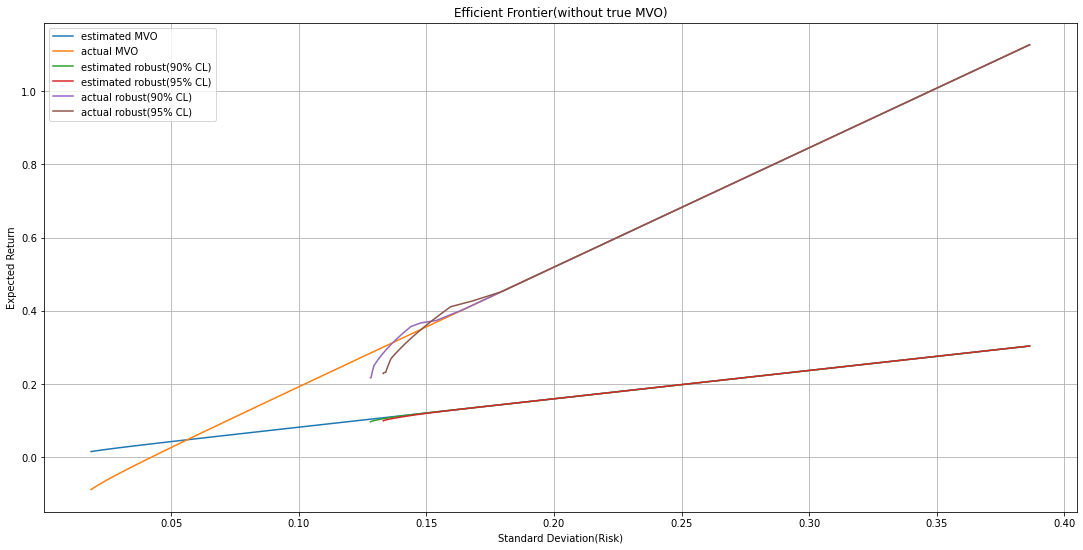

In [60]:
# efficient frontiers without True MVO frontier

fig = plt.gcf()
fig.set_size_inches(18.5, 9)
ax = plt.gca()
ax.plot(np.sqrt(var_list1), ret_list1, label='estimated MVO')
#ax.plot(np.sqrt(var_list2), ret_list2, label='true MVO')
ax.plot(np.sqrt(var_list3), ret_list3, label='actual MVO')
ax.plot(np.sqrt(var_list4), ret_list4, label='estimated robust(90% CL)')
ax.plot(np.sqrt(var_list5), ret_list5, label='estimated robust(95% CL)')
ax.plot(np.sqrt(var_list6), ret_list6, label='actual robust(90% CL)')
ax.plot(np.sqrt(var_list7), ret_list7, label='actual robust(95% CL)')

#ax.set(xlim=(0, 0.4))
#ax.set(ylim=(0, 4))
ax.set_xlabel('Standard Deviation(Risk)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier(without true MVO)')
ax.legend()
ax.grid()
plt.show()

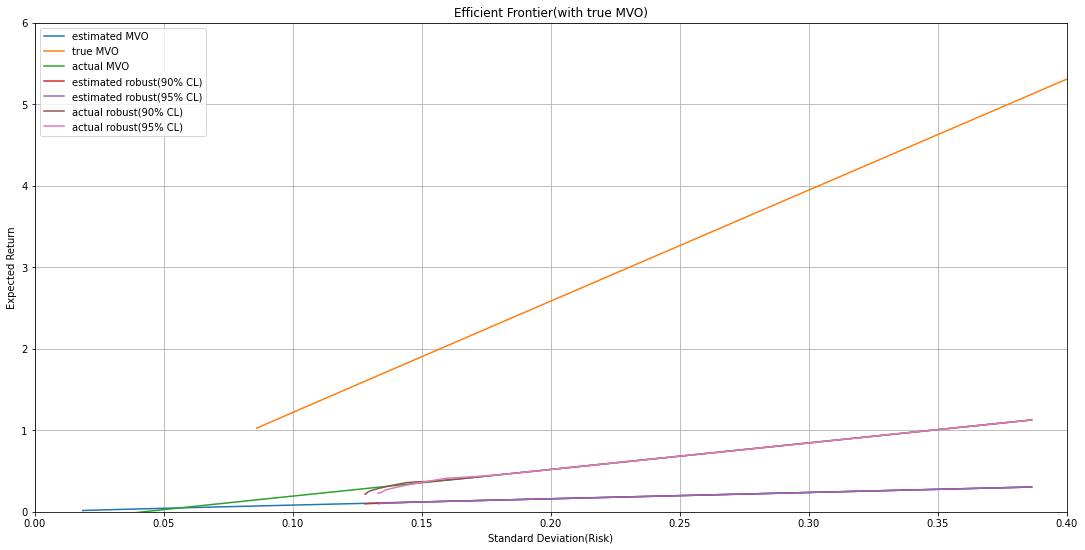

In [61]:
# efficient frontiers with True MVO frontier

fig = plt.gcf()
fig.set_size_inches(18.5, 9)
ax = plt.gca()
ax.plot(np.sqrt(var_list1), ret_list1, label='estimated MVO')
ax.plot(np.sqrt(var_list2), ret_list2, label='true MVO')
ax.plot(np.sqrt(var_list3), ret_list3, label='actual MVO')
ax.plot(np.sqrt(var_list4), ret_list4, label='estimated robust(90% CL)')
ax.plot(np.sqrt(var_list5), ret_list5, label='estimated robust(95% CL)')
ax.plot(np.sqrt(var_list6), ret_list6, label='actual robust(90% CL)')
ax.plot(np.sqrt(var_list7), ret_list7, label='actual robust(95% CL)')

ax.set(xlim=(0, 0.4))
ax.set(ylim=(0, 6))
ax.set_xlabel('Standard Deviation(Risk)')
ax.set_ylabel('Expected Return')
plt.title('Efficient Frontier(with true MVO)')
ax.legend()
ax.grid()
plt.show()